## Reader의 추천 알고리즘
이 노트북은 Reader의 추천알고리즘을 구현하기 위해 Kaggle의 도서 평점 데이터를 전처리, 학습시키는 코드를 담고 있습니다. 데이터는 아래 url에서 받으실 수 있습니다.

▶ [도서 평점 데이터](https://www.kaggle.com/bahramjannesarr/goodreads-book-datasets-10m?select=user_rating_0_to_1000.csv)


In [ ]:
import pandas as pd
import numpy as np

u_cols = ['user_id', 'book', 'rating']
ratings = pd.read_csv('/content/user_rating_0_to_1000.csv', sep=',', names=u_cols, encoding='latin-1')

ratings.set_index('user_id')
print(ratings)

drop_idx = ratings[ratings['book'] == 'Rating'].index 
ratings = ratings.drop(drop_idx) # 평가데이터가 존재하지 않는 사용자를 제거
print(ratings)

      user_id  ...           rating
0          ID  ...           Rating
1           1  ...   it was amazing
2           1  ...   it was amazing
3           1  ...   it was amazing
4           1  ...  really liked it
...       ...  ...              ...
51941     999  ...        it was ok
51942     999  ...   it was amazing
51943     999  ...   it was amazing
51944     999  ...   it was amazing
51945     999  ...   it was amazing

[51946 rows x 3 columns]
      user_id  ...           rating
0          ID  ...           Rating
1           1  ...   it was amazing
2           1  ...   it was amazing
3           1  ...   it was amazing
4           1  ...  really liked it
...       ...  ...              ...
51941     999  ...        it was ok
51942     999  ...   it was amazing
51943     999  ...   it was amazing
51944     999  ...   it was amazing
51945     999  ...   it was amazing

[51643 rows x 3 columns]


### book 데이터 전처리
책 데이터를 처리하기 쉽게, 각 책마다 아이디를 부여합니다.
또한, 몇 권의 책이 데이터에 포함되어 있는지, 평가수가 가장 많은 책은 어떤 책인지 확인해 봅니다.

In [ ]:
books = np.array(ratings['book'])

id_to_book = {}
book_to_id = {}
num_book = {}

for book in books:
  if book not in id_to_book.values():
    new_idx = len(id_to_book)
    id_to_book[new_idx] = book
    book_to_id[book] = new_idx
    num_book[new_idx] = 1
  else:
    num_book[book_to_id[book]] += 1

print("책 종류 수 : %d" % len(id_to_book))

num_book_sort = sorted(num_book.items(), reverse=True, key = lambda x : x[1])
key_max = num_book_sort[0][0]
print("가장 평가데이터가 많은 책 : %s %d" % (id_to_book[key_max], num_book[key_max]))

책 종류 수 : 24094
가장 평가데이터가 많은 책 : The Kite Runner 126


평가데이터 도서 항목을 제목 대신 아이디로 교체합니다.

In [ ]:
ratings['book'] = ratings['book'].apply(lambda x : book_to_id[x])
print(ratings['book'])

0            0
1            1
2            2
3            3
4            4
         ...  
51940    24092
51941    15354
51942      448
51943    12404
51944     7602
Name: book, Length: 51642, dtype: int64


### 점수 데이터 전처리
문장으로 되어 있는 평가데이터를 숫자로 변환합니다. 사용자들이 가장 많이 매긴 점수 항목을 확인하고, 데이터 형식을 확인합니다.

In [ ]:
ratings_val = np.array(ratings['rating'])

id_to_rating = {}
rating_to_id = {}
num = {}

for rating in ratings_val:
  if rating not in rating_to_id.keys():
    new_idx = len(rating_to_id)
    id_to_rating[new_idx] = rating
    rating_to_id[rating] = new_idx
    num[new_idx] = 1
  else:
    num[rating_to_id[rating]] += 1

"""
it was amazing - 5점
really liked it - 4점
liked it - 3점
it was ok - 2점
did not like it - 1점
"""

num_sort = sorted(num.items(), reverse=True, key = lambda x : x[1])
key_max = num_sort[0][0]
print(id_to_rating[key_max], num[key_max])

really liked it 20282


점수 데이터를 모두 숫자로 변경합니다.

In [ ]:
rating_to_id['did not like it'] = 1
rating_to_id['it was ok'] = 2
rating_to_id['liked it'] = 3
rating_to_id['really liked it'] = 4
rating_to_id['it was amazing'] = 5

ratings['rating'] = ratings['rating'].apply(lambda x : rating_to_id[x])
print(ratings['rating'])

0        5
1        5
2        5
3        4
4        4
        ..
51940    2
51941    5
51942    5
51943    5
51944    5
Name: rating, Length: 51642, dtype: int64


1부터 시작하는 사용자 아이디를 1씩 줄여서 0부터 시작되도록 합니다.

In [ ]:
ratings['user_id'] = ratings['user_id'].apply(lambda x : x-1)
print(ratings['user_id'])

0          0
1          0
2          0
3          0
4          0
        ... 
51940    998
51941    998
51942    998
51943    998
51944    998
Name: user_id, Length: 51642, dtype: int64


### 사용자 평점을 예측하는 딥러닝 모델 구축
MF(행렬 분해)를 기반으로 한 model-based 딥러닝 모델로, 사용자 평점 예측 모델을 구축합니다. 모델 학습 이후, 가중치를 저장합니다.

Epoch 1/100
76/76 [==============================] - 9s 111ms/step - loss: 42.6892 - RMSE: 0.9425 - val_loss: 41.7489 - val_RMSE: 0.9439
Epoch 2/100
76/76 [==============================] - 8s 107ms/step - loss: 41.4424 - RMSE: 0.9458 - val_loss: 40.5266 - val_RMSE: 0.9435
Epoch 3/100
76/76 [==============================] - 8s 106ms/step - loss: 40.2318 - RMSE: 0.9479 - val_loss: 39.3410 - val_RMSE: 0.9432
Epoch 4/100
76/76 [==============================] - 8s 108ms/step - loss: 39.0530 - RMSE: 0.9455 - val_loss: 38.1910 - val_RMSE: 0.9430
Epoch 5/100
76/76 [==============================] - 8s 108ms/step - loss: 37.9165 - RMSE: 0.9501 - val_loss: 37.0753 - val_RMSE: 0.9427
Epoch 6/100
76/76 [==============================] - 8s 109ms/step - loss: 36.8051 - RMSE: 0.9456 - val_loss: 35.9930 - val_RMSE: 0.9425
Epoch 7/100
76/76 [==============================] - 8s 108ms/step - loss: 35.7301 - RMSE: 0.9445 - val_loss: 34.9432 - val_RMSE: 0.9422
Epoch 8/100
76/76 [======================

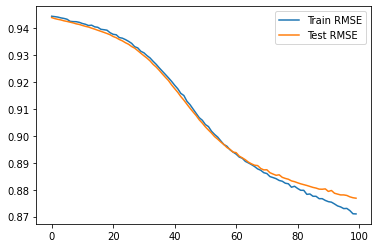

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Activation, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from sklearn.utils import shuffle

TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state = 1)
cut_off = int(len(ratings) * 0.75)
ratings_train = ratings[:cut_off]
ratings_test = ratings[cut_off:]

K = 200
mu = ratings_train['rating'].mean()
M = ratings['user_id'].max() + 1
N = ratings['book'].max() + 1

# 손실함수
def RMSE(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

user = Input(shape = (1,))
item = Input(shape = (1,))
P_embedding = Embedding(M, K, embeddings_regularizer=l2(), name='user_vec')(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2(), name='book_vec')(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dropout(0.3)(R)
R = Dense(256)(R)
R = Activation('relu')(R)
R = Dense(1)(R)

model = Model(inputs = [user, item], outputs = R)
model.compile(
    loss = RMSE,
    optimizer = SGD(),
    metrics = [RMSE]
)

results = model.fit(
    x = [ratings_train['user_id'].values, ratings_train['book'].values],
    y = ratings_train['rating'].values - mu,
    epochs = 100,
    batch_size = 512,
    validation_data = (
        [ratings_test['user_id'].values, ratings_test['book'].values],
        ratings_test['rating'].values - mu
    )
)

# 모델 저장하기
model.save('book_recom_model.h5')
model.save_weights('model_weight.h5')

# 결과값 시각화 하기
plt.plot(results.history['RMSE'], label = "Train RMSE")
plt.plot(results.history['val_RMSE'], label = "Test RMSE")
plt.legend()
plt.show()

In [ ]:
model = Model(inputs = [user, item], outputs = R)
model.load_weights(filepath='/content/model_weight.h5')

books = pd.read_csv('/content/book_1000.csv', sep=',', index_col='id', encoding='latin-1')

for i in range(100):
  book_ids = np.array(books.index)
  user_ids = np.array([i] * 1000)
  predictions = model.predict([user_ids, book_ids]) + mu
  predictions = predictions.reshape(-1)
  idx = np.argsort(predictions)[::-1]
  print(book_ids[idx][:50])

[  48   71  394    5 1039  307  300  210  290  198 1307  435 1381  471
  231  355   27   61  359 1612  503  786  158 1196  270 3686  737  569
   98  448  728 2800  564  272  370  261  207  500  875  414  376  833
  349 2843  195 1129 2229 1009 1143  706]
[  48   71  394    5 1039  307  300  210  198  290 1307  435 1381  471
  231  355   27   61 1612  359  503  786  158 1196  270 3686   98  569
  737  728  564  370  448  500 2800  875  272  207  414  261  349  376
 2229  833 1143  195  706 2843 3926 1129]
[  48   71  394    5 1039  307  300  210  290  198 1307  435 1381  471
  231  355   27   61  359  503 1612  786  158  270 1196 3686  569   98
  564  448  737  728  370  875  272  500 2800  207  261  414 2229  195
  376  349 2843  833 1009 1143 1163 1129]
[  48   71  394    5 1039  307  300  210  290  198 1307  435 1381  471
  231  355   27   61  359 1612  786  503  158 1196  270 3686  569   98
  737 2800  448  728  261  564  207  500  272  370  875  376  414  833
  349  195 2843 2229 1

각 도서의 임베딩 벡터의 코사인 유사도(cosine similarity)를 기반으로, 특정 도서화 가장 연관 있는 도서를 추출하는 코드이다. 아래 코드는 책 id '673'인 도서를 기준으로 가장 연관 있는 도서 50권을 계산하는 코드이다.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

book_vec = model.get_layer('book_vec').weights
bias_vec = model.get_layer('book_bias_vec').weights

book_vec = np.array(book_vec[0])
bias_vec = np.array(bias_vec[0])

# book_vec += bias_vec

cosine_dic = {}
v1 = book_vec[673].reshape(1, -1)
for i in range(book_vec.shape[0]):
  if i == 673:
    continue
  v2 = book_vec[i].reshape(1, -1)
  cosine_dic[i] = float(cosine_similarity(v1, v2))

cosine_dic = sorted(cosine_dic.items(), reverse=True, key = lambda x : x[1])
for id, val in cosine_dic[0:50]:
  print(id_to_book[id], val)

Falling in Love (Commissario Brunetti, #24) 0.2828589379787445
Giving Offense: Essays on Censorship 0.2824245095252991
Roast Figs, Sugar Snow 0.26938021183013916
The Shadow of Sirius 0.2576732337474823
The Wind-Up Bird Chronicle 0.25722619891166687
Learning from the Heart: Lessons on Living, Loving, and Listening 0.2530573010444641
Station Eleven 0.2490752935409546
The Lost Continent: Travels in Small Town America 0.24840736389160156
Opening Belle 0.24748332798480988
This Will Make You Smarter: New Scientific Concepts to Improve Your Thinking 0.24563416838645935
Visitation Street 0.24195581674575806
Lucy 0.24164488911628723
About That Fling 0.24080528318881989
Martin Dressler: The Tale of an American Dreamer 0.2363656759262085
The First Four Books of Sampson Starkweather 0.22729706764221191
On Dublin Street (On Dublin Street, #1) 0.22632721066474915
Words Will Break Cement: The Passion of Pussy Riot 0.2252417355775833
Girl in Translation 0.2216532826423645
Breaking the Spell: Religion 

평가데이터가 가장 많은 책 100권을 뽑아, csv 파일로 저장한다.

In [ ]:
id_to_book_1000 = num_book_sort[:100]

id_1000 = [idx for idx, val in id_to_book_1000]
book_1000 = [id_to_book[idx] for idx, val in id_to_book_1000]
df = pd.DataFrame({'id': id_1000, 'book': book_1000})
df.to_csv('book.csv', index=False) # 가장 평가 데이터가 많은 책 1000권을 따로 저장

위에서 추출한, 평가데이터가 가장 많은 책 100권을 기준으로, 가장 연관있는 도서 50권을 계산하는 코드이다.

In [ ]:
cosine_dic_1000 = {}

print(id_to_book[270])
v1 = book_vec[270].reshape(1, -1)
for key, val in id_to_book_1000:
  if key == 270:
    continue
  v2 = book_vec[key].reshape(1, -1)
  cosine_dic_1000[key] = float(cosine_similarity(v1, v2))

cosine_dic_1000 = sorted(cosine_dic_1000.items(), reverse=True, key = lambda x : x[1])
for id, val in cosine_dic_1000[0:50]:
  print(id_to_book[id], val)

1984
Slaughterhouse-Five 0.4992491602897644
Dress Your Family in Corduroy and Denim 0.4841062128543854
Bel Canto 0.46693605184555054
The Joy Luck Club 0.4445004463195801
Romeo and Juliet 0.44134292006492615
Atonement 0.44002407789230347
The Kite Runner 0.4362126588821411
The Grapes of Wrath 0.4337741732597351
Harry Potter and the Half-Blood Prince (Harry Potter, #6) 0.43283364176750183
The Glass Castle 0.4305427670478821
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3) 0.41996893286705017
Naked 0.4173972010612488
Macbeth 0.4053196609020233
The Corrections 0.3979886472225189
Fahrenheit 451 0.39794933795928955
Harry Potter and the Sorcerer's Stone (Harry Potter, #1) 0.3976838290691376
One Hundred Years of Solitude 0.3976699113845825
Harry Potter and the Goblet of Fire (Harry Potter, #4) 0.38046836853027344
Ender's Game (Ender's Saga, #1) 0.3740403652191162
The Adventures of Huckleberry Finn 0.35969144105911255
A Confederacy of Dunces 0.3435007929801941
Gone with the Wind 0.329